In [ ]:
# Global/WindowsApps (3.9.13)
!pip3 install --user fredapi
!pip3 install --user matplotlib
!pip3 install --user numpy
!pip3 install --user scipy
!pip3 install --user pandas
!pip3 install --user seaborn
!pip3 install --user sklearn

In [1]:
from fredapi import Fred
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from dateutil import relativedelta


key = os.environ.get('FRED_KEY')
fred = Fred(api_key=key)


In [2]:
def normalize(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    std_df=(df-df.mean())/df.std()
    return std_df

def dual_plot(a,b):
    fig,ax1 = plt.subplots()
    ax1.plot(a,c='darkgray')
    #ax1.set_yscale('log')
    ax2 = ax1.twinx()
    ax2.plot(b,c='goldenrod')
    plt.plot()

def get_next_month(today:datetime):
    nextmonth = today + relativedelta.relativedelta(months=1)
    return nextmonth

date_to_index = lambda x: x.astype('str')
index_to_date = lambda x: pd.to_datetime(x.index)

In [3]:
start= "2004-01-03"
end  = "2022-06-03"

indicator   = fred.get_series('T5YIFR',observation_start=start, observation_end=end)
#indicator   = fred.get_series('AMTMNO',observation_start=start, observation_end=end)
stock = fred.get_series('NASDAQ100',observation_start=start, observation_end=end)


# Dataset 생성

In [4]:
def kernel(indicator_set, stock_set, WINDOW:int):
    score = np.array([], dtype=np.float32)
    len_index = indicator_set.index
    len_index = int(len(len_index)/WINDOW)
    #print(len_index)
    for i in range(len_index):
        _indicator   = indicator_set.iloc  [WINDOW*i : WINDOW*(i+1)]
        _stock = stock_set.iloc[WINDOW*i : WINDOW*(i+1)]
        _indicator   = normalize(_indicator)
        _stock = normalize(_stock)

        df = pd.DataFrame()
        df.index = _indicator.index
        df['indicator']  = normalize(_indicator)
        df['stock'] = normalize(_stock)

        score = np.append(score, df.corr().indicator.stock)

    np.random.shuffle(score)
    score = pd.Series(score)
    mean_score = round(score.mean(),2)
    #print(mean_score)
    return normalize(score)


def split_dataset(dataset, prob:list = [0.7, 0.2, 0.1]):
    _len = len(dataset)
    ptr = 0
    training_set   = dataset.iloc[:int(_len*prob[0])]
    ptr += int(_len*prob[0])
    validation_set = dataset.iloc[ptr: ptr+int(_len*prob[1])]
    ptr += int(_len*prob[1])
    test_set       = dataset.iloc[ptr:ptr+int(_len*prob[2])]
    return training_set, validation_set, test_set

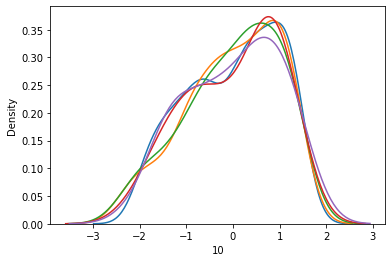

In [5]:
indicator_set, stock_set = indicator, stock

windows = [10,30,60,90,120]
scores = pd.DataFrame([])

for i,w in enumerate(windows):
    scores[str(w)] = kernel(indicator_set, stock_set, w)
    sns.kdeplot(data=scores[str(w)])

# Fit

480 336 96 48


<AxesSubplot:xlabel='10', ylabel='Count'>

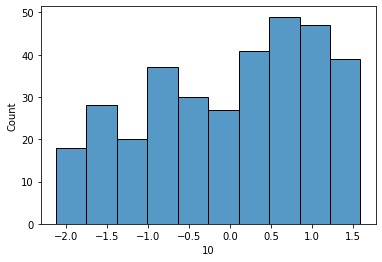

In [16]:
sel_dset = scores[str(windows[0])].dropna()
training_set,validation_set, test_set = split_dataset(sel_dset)

print(len(sel_dset),len(training_set), len(validation_set),len(test_set) )

sns.histplot(data= training_set)

In [17]:
import numpy as np
from sklearn.mixture import GaussianMixture
if 0:
    kde = sns.kdeplot(data=training_set)
    line = kde.lines[0]
    X, y = line.get_data()
    fit_data = y.reshape(-1,1)
else:
    fit_data = training_set.values.reshape(-1,1)
GMM = GaussianMixture(n_components=2, ).fit(fit_data)

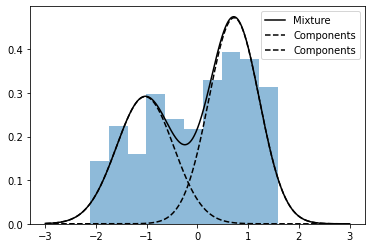

In [18]:
# plot resulting fit
x_range = np.linspace(-3, 3, 1000)

pdf = np.exp(GMM.score_samples(x_range.reshape(-1, 1)))


responsibilities = GMM.predict_proba(x_range.reshape(-1, 1))


pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(fit_data, bins='auto', density=True, histtype='stepfilled', alpha=0.5)
plt.plot(x_range, pdf, '-k', label='Mixture')
plt.plot(x_range, pdf_individual, '--k', label='Components')
plt.legend()
plt.show()

# Predict

In [19]:

predict =  GMM.predict_proba(test_set.values.reshape(-1, 1))

In [22]:
np.argmax(predict,axis=1)

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1], dtype=int64)